In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import Callback
import os
import keras.backend as K

Using TensorFlow backend.


In [3]:
bs = 64
num_classes = 10
epochs = 5

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
def four_layer_model():
 
    model = Sequential()
  
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    
    model.add(Conv2D(32,(3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
 
    return model

In [6]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [8]:
model4 = four_layer_model()
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [7]:
model4 = four_layer_model()
model4.compile(loss='categorical_crossentropy', optimizer='ADAM', metrics=['accuracy'])

In [8]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(x_train.shape[0]/bs))
model4.fit(x_train, y_train, callbacks=[lr_finder] )

Epoch 1/1
26528/50000 [==============>...............] - ETA: 8s - loss: 2.8260 - acc: 0.1400

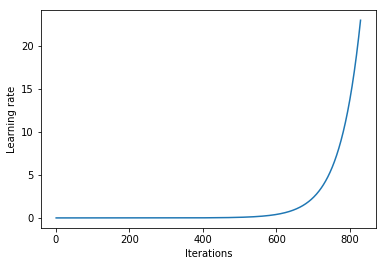

In [9]:
lr_finder.plot_lr()

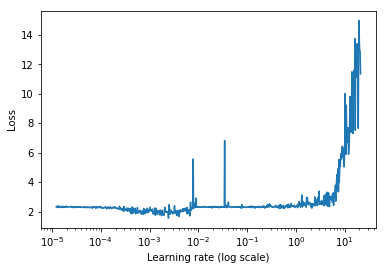

In [10]:
lr_finder.plot()

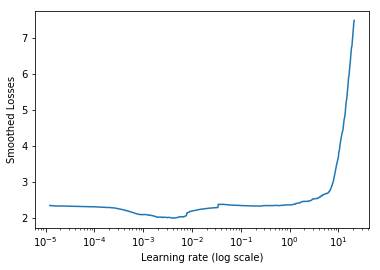

In [11]:
lr_finder.plot_smoothed_loss()

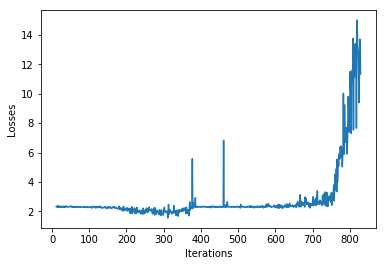

In [12]:
lr_finder.plot_loss()